# 7-1. 들어가며

지금까지 딥러닝 모델을 기반으로 이미지를 분류, 탐지하는 여러 가지 모델을 공부해 오셨을 것입니다. 이미지를 모델의 입력에 맞게 전처리해주고 모델에 통과시킨 뒤 결과를 해석해서 추론값을 얻어내는 과정이 익숙하실 것입니다.

그런데 모델이 잘 동작한다는 것을 확인하고 끝내기에는 궁금한 것들이 많습니다. 예를 들면 개와 고양이를 분류하는 딥러닝 모델을 만들었다고 합시다. 이 모델이 이미지의 어느 부분을 보고 개라는 결론을 내렸는지 알 수 있을까요? 그동안 우리가 다룬 딥러닝은 모델의 추론 근거를 알 수 없는 블랙박스(Black Box) 모델이었습니다. 그래서 이 모델을 신뢰할 수 있는지조차 명확하지 않았죠. 그래서 이번 시간에는 모델과 추론의 신뢰성에 대한 답을 찾는 XAI(Explainable Artificial Intelligence, 설명 가능한 인공지능) 분야에 대해 알아보겠습니다. XAI 기법은 모델의 성능을 개선할 수 있는 단서로도 유용하게 활용될 것입니다.

### 학습 내용
---
2. Explainable AI
- XAI(explainable AI)가 어떤 의미인지 알아봅니다.
3. CAM: Class Activation Map
- 모델이 어떤 곳을 보고 어떤 클래스임을 짐작하고 있는지를 확인하는 CAM을 알아봅니다.
4. Grad-CAM
- Gradient CAM의 특징을 살펴보고, CAM과의 차이점을 알아봅니다.
5. ACoL: Adversarial Complementary Learning
- Weaky-supervised 방식의 Object Detection, Segmentation 방법론을 알아봅니다.
6. 생각해 보기
- CAM을 활용한 프로젝트를 알아봅니다.

### 실습목표
---
1. 분류 모델의 활성화 맵을 이해하고, CAM을 설명할 수 있습니다.
2. 다양한 활성화 맵을 구하는 방법을 설명할 수 있습니다.
3. 약지도학습(weakly supervised learning)을 설명할 수 있습니다.

# 7-2. Explainable AI

많은 AI 모델들이 다양한 분야에 적용되어 좋은 성과를 내고 있습니다. 하지만 이렇게 현실 문제에 신경망 모델을 적용할 때에는 실습 문제를 풀 때처럼 단순히 모델의 가중치(weight)를 최적화하는 과정만을 믿고, 곧바로 모델이 올바르게 동작한다고 넘겨짚기는 어렵습니다.

이때 모델이 잘못된 답변을 준다면 어떻게 개선할 수 있을지, 잘 동작한다면 왜 이런 선택을 했는지 알고자 하는 것을 XAI(explainable AI) 라고 합니다. 아래 영상을 보고 XAI가 어떤 것이며 왜 필요한 것인지 알아보도록 합시다.

https://youtu.be/U43fxbC-4JQ

### 이미지 분류 문제(Image Classification)
---
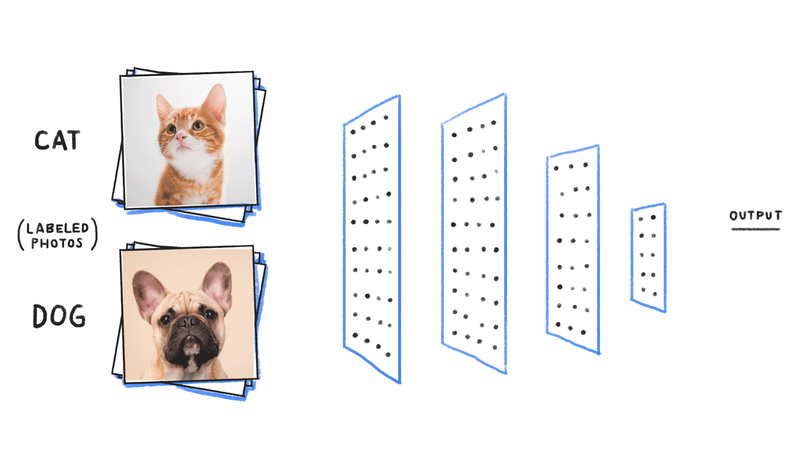  
https://3months.tistory.com/465  

위 그림처럼 분류모델에 이미지가 입력으로 들어온다고 생각해봅시다. 먼저 일반적인 이미지 분류 모델은 이미지의 local feature를 추출하기 위해 CNN으로 구성된 특성 추출용 백본 네트워크(backbone network)가 앞에 있습니다. 백본 네트워크에서 추출된 특성 맵(feature map)을 fully connected layer에 통과시켜 얻어진 logit을 소프트맥스(softmax) 활성화 함수에 통과시키면, 입력 이미지가 각 클래스에 속할 확률을 얻을 수 있습니다.

여기서 잠깐, logit, sigmoid, softmax 함수의 관계에 대해 잠시 짚고 넘어갑시다.

- 참고: 한 페이지 머신러닝-logit, sigmoid, softmax의 관계  
https://opentutorials.org/module/3653/22995  

위 링크의 설명을 통해, logit이 아래와 같이 sigmoid의 역함수이며, softmax는 sigmoid를 K개의 클래스로 일반화한 것임을 알 수 있습니다.  

이런 이미지 분류 모델에서 얻어진 logit 값이 K개의 클래스 중 하나가 정답이라고 가리킨다면, 혹시 그렇게 분류할 수 있는 근거를 이미지 분류 모델 안에서 찾아볼 수 있을까요?

#### Q. 이미지 분류 문제에서 딥러닝 모델이 어떤 클래스로 정답을 냈을 때, 모델 내부에서 그 이유를 찾아볼 수 있는 방법은 어떤 것이 있을지 생각해 봅시다.

레이어마다 feature map을 시각화해서, activation이 어떻게 되어있는지 확인해 볼 수 있을 것 같습니다.

1. 시각화 기반 기법
2. 피처 기여도 분석
3. 모델 내부 메커니즘 분석
4. 샘플 기반 기법
5. 모델 단순화 (Proxy Models)

# 7-3. CAM: Class Activation Map

많은 연구자들이 앞서 대답하신 질문의 답을 찾으려 노력해 왔습니다. 지금부터 배울 CAM(Class Activation Map) 은 이미지 분류 분야에서의 노력의 결과 중 하나입니다.

CAM이라는 단어를 보면 카메라가 떠오르실 텐데요. 여기서 CAM은 _Class Activation Map_을 뜻합니다. 단순화시켜 이야기하면 "모델이 어떤 곳을 보고 어떤 클래스임을 짐작하고 있는지" 확인할 수 있는 지도 입니다. CAM은 MIT 연구진의 Learning Deep Features for Discriminative Localization https://arxiv.org/abs/1512.04150 논문에서 확인할 수 있습니다.

우선 위 논문의 저자인 Bolei Zhou의 What the CNN is looking 영상을 보고 CNN이 어떤 영역을 활성화시키는지 확인해 보도록 합시다.  
https://youtu.be/fZvOy0VXWAI  

본격적으로 CAM을 공부하기 전에 먼저 논문에 나오는 GAP(Global Average Pooling) 기법부터 공부하겠습니다. CAM 논문의 연구진은 CAM을 얻기 위해서 GAP을 사용했으며, 이를 통해서 어떤 클래스가 어느 영역에 의해서 활성화되었는지 알 수 있도록 합니다.

### 1) GAP(Global Average Pooling)
---
>주요 참고 자료
    - Network In Network - 논문  https://arxiv.org/abs/1312.4400  
    - [Network-in-Network-리뷰] https://modulabs.co.kr/blog/network-in-network  
    
https://youtu.be/8oOgPUO-TBY  

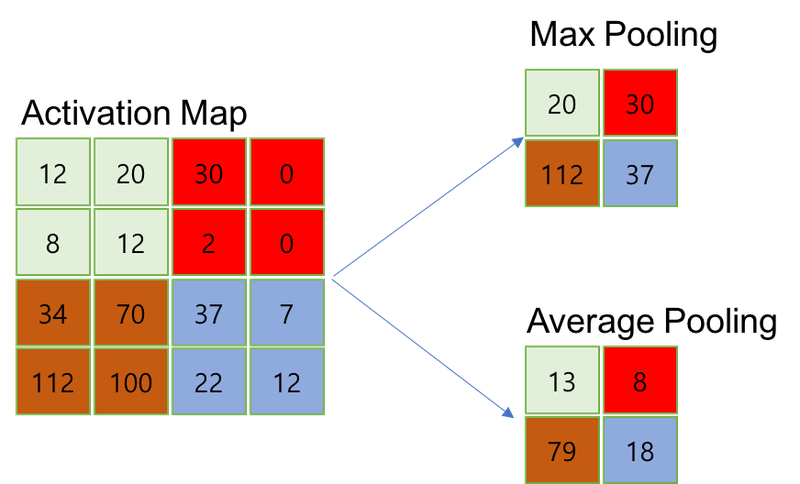   
http://taewan.kim/post/cnn/

#### Q. Pooling에는 average pooling과 max pooling 등이 있습니다. 위 그림을 참고하여, Average pooling과 Max pooling은 어떻게 다른지 설명해 보세요.

Max Pooling: 중요한 특징(최대값)을 강조하는 데 적합하며 주로 이미지 분류에서 사용  
Average Pooling: 전체 정보를 균형 있게 유지하여 부드러운 결과가 필요한 경우 사용  

Average pooling과 Max pooling은 각각 커널과 겹치는 영역에 대해 Average 값을 취한 것과 Max 값을 취한 것입니다.

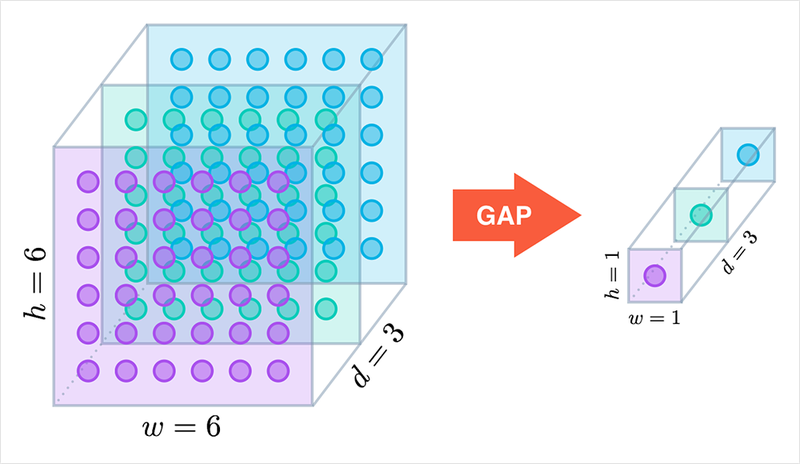  

분류 모델의 마지막 부분에서 fully connected layer 대신 GAP을 사용하는 방법은 Network in Network라는 논문에서 제안되었습니다.
https://arxiv.org/pdf/1312.4400  

일반적으로 이미지 분류에서는 여러 CNN 레이어를 거쳐 우선 특성을 추출하고, 그 특성 맵을 flattening 한 후 fully connected layer에 입력해 줌으로써 각 클래스에 따른 logit을 구하고 최종적으로 활성화 함수를 거치게 합니다.

그러나 Network in Network 논문에서는 CNN 이후 fully connected layer 대신 GAP 연산을 합니다. GAP(Global Average Pooling)은 매 채널별로, average pooling을 채널의 값 전체에 global하게 적용합니다. 위 그림에서 볼 수 있듯이 크기가 6x6이고 채널이 3개인 특성맵에 대해서 GAP을 수행하면 각 채널이 딱 한 개의 숫자로 요약되어, 1x1 크기의 채널이 3개인 벡터를 얻게 됩니다. 이때 결과 벡터의 각 차원의 값은 6x6 크기의 특성 맵을 채널별로 평균을 낸 값입니다. Pooling 기법에 대해서 더 알고 싶으시다면 위 참고자료 중 C4W1L09 Pooling Layers에서 Andrew Ng 교수님의 설명을 확인하시기 바랍니다.  
https://www.youtube.com/watch?v=8oOgPUO-TBY  

아래 그림처럼 GAP 연산을 하고, 그 연산 결과에 소프트맥스 활성화 함수를 적용합니다. 이때 마지막 CNN 레이어의 채널 수는 데이터의 클래스 수에 맞춰 각 클래스에 따른 확률을 얻을 수 있도록 했습니다. 원 논문에서는 이렇게 하면 특성 맵의 각 채널이 클래스별 신뢰도를 나타내게 되어 해석이 쉬울 뿐만 아니라, fully connected layer와 달리 최적화할 파라미터가 존재하지 않으므로 과적합(overfitting)을 방지할 수 있다고 설명합니다.  
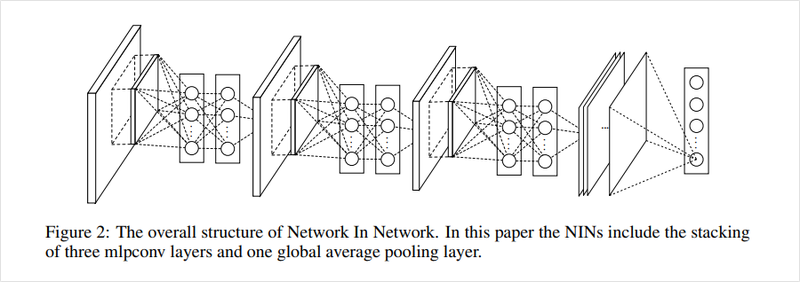  

### 2) CAM
> 주요 참고 자료
    - Learning Deep Features for Discriminative Localization http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf   
    - [논문리뷰] - Learning Deep Features for Discriminative Localization, CVPR 2016 https://joungheekim.github.io/2020/09/29/paper-review/  
    
CAM(Class Activation Map) 은 이름에서 알 수 있듯이 클래스가 활성화되는 지도입니다. 일반적인 CNN은 커널 윈도우에 따라서 특성을 추출하므로 CNN 레이어를 거친 특성 맵에도 입력값의 위치정보가 유지됩니다. 따라서 특성 맵의 정보를 이미지 검출(detection)이나 세그멘테이션(Segmentation) 등의 문제를 푸는 데 이용하기도 합니다.  
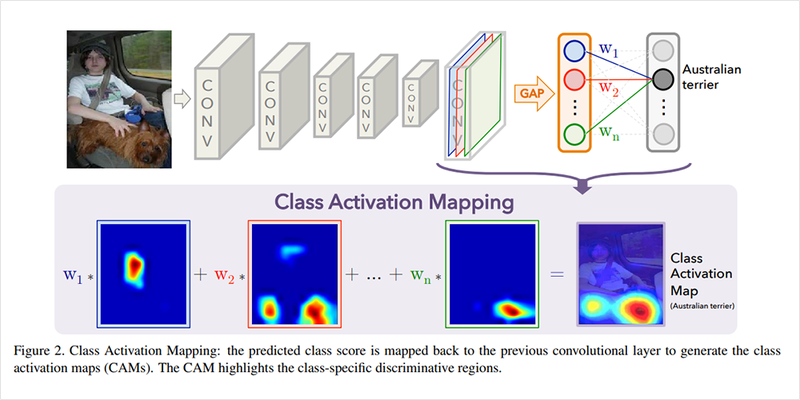  
http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf  

CAM을 얻을 수 있는 네트워크는 위 그림에서 볼 수 있습니다. 먼저 CNN 레이어를 거쳐 뽑아낸 특성 맵에 대해서 GAP을 적용합니다. 그리고 이에 대해서 소프트맥스 레이어(소프트맥스 활성화 함수를 가지고 bias가 없는 fully connected layer)를 적용합니다.

CNN을 거친 특성맵에서 각 클래스에 대한 정보는 결괏값의 여러 채널에 걸쳐 나타나게 됩니다. GAP을 통해 각 채널별 정보를 요약하면 소프트맥스 레이어는 이 정보를 보고 각 클래스에 대한 개별 채널의 중요도를 결정합니다. 이렇게 클래스별로 소프트맥스 레이어를 통해 각 채널의 가중합을 구하면 각 클래스가 활성화 맵의 어떤 부분을 주로 활성화시키는지 확인할 수 있습니다.

이렇게 얻은 특성 맵은 CNN의 출력값 크기와 같게 됩니다. 이를 보간(interpolation)을 통해 적절히 원본 이미지 크기로 확대해 주면 위와 같은 CAM을 얻을 수 있습니다.

이제 수식을 하나씩 살펴보도록 하겠습니다. 아래 수식은 위 그림을 수식으로 설명한 것에 불과하므로, 위 그림과 비교하여 살펴봅시다.  
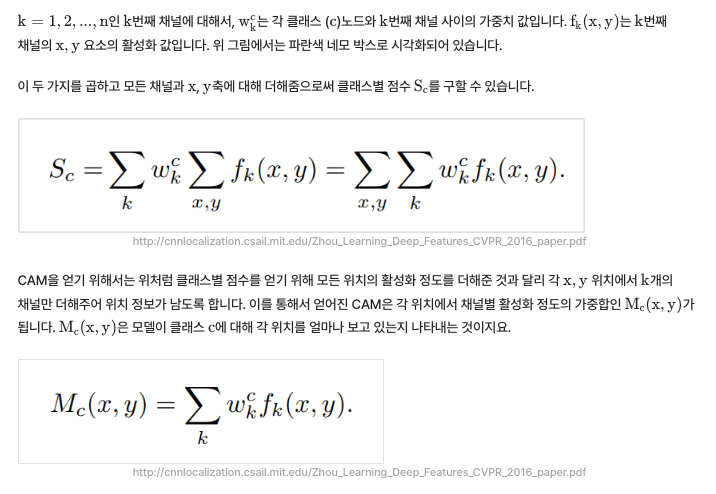


### 참고
> 글로벌 평균 풀링의 한 가지 장점은 완전 연결 층보다 합성곱 구조에 더 적합하다는 것입니다. 이는 특징 맵과 카테고리 간의 대응 관계를 강제하여 특징 맵을 카테고리 신뢰도 맵으로 쉽게 해석할 수 있게 합니다. 또 다른 장점은 글로벌 평균 풀링에는 최적화할 매개변수가 없으므로 과적합이 방지된다는 것입니다. 또한, 글로벌 평균 풀링은 공간 정보를 합산하여 입력의 공간적 변환에 더 강인합니다.

# 7-4. Grad-CAM

> 주요 참고 자료  
    - Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization  https://arxiv.org/abs/1610.02391  

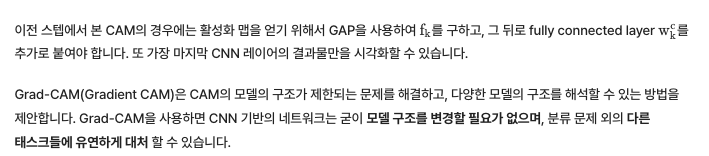
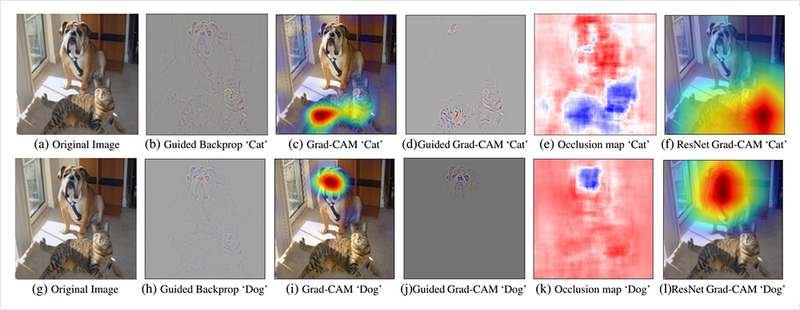
https://arxiv.org/pdf/1610.02391.pdf  

위의 이미지는 개와 고양이가 있는 이미지에 대해서 Guided Backprop, Grad-CAM, Occlussion map의 시각화를 비교하고 있습니다. Grad-CAM에서는 높은 분별력과 큰 dimension을 갖는 CAM을 만드는 것을 중요하게 보았습니다.

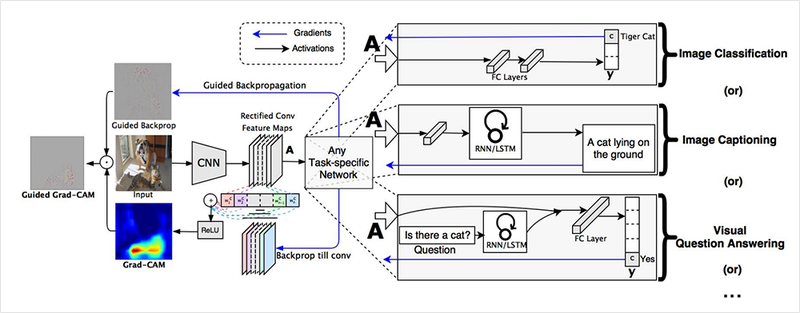
https://arxiv.org/pdf/1610.02391.pdf  
Grad-CAM의 전체적인 구조는 위와 같습니다. 그림의 왼쪽에서 모델의 구조를 볼 수 있습니다. 위에서 보았던 이미지를 입력으로 CNN을 거쳐 특성 맵을 추출하고 그 뒤로 태스크에 따라서 다양한 레이어들이 사용됩니다.

오른쪽의 "Image Classification"과 "Image captioning", "Visual question Answering"은 Grad-CAM이 적용될 수 있는 다양한 컴퓨터 비전 문제들을 설명합니다. Image Classification은 익히 들어오셨겠지만 Image Captioning이나 Visual Question answering은 생소하실 텐데요, Image Captioning은 이미지에 대한 설명을 만들어내는 태스크입니다. Visual question answering은 VQA라고도 불리며, 어떤 질문과 이미지가 주어졌을 때 이에 대한 답변을 내는 태스크입니다.

이렇게 복잡한 모델들은 다양한 모델이 동시에 사용되기 때문에 설명하기가 매우 어렵습니다. Grad-CAM은 복잡한 태스크에 사용되는 모델에서도 사용될 수 있다는 점을 장점으로 내세웁니다.  

### 그래디언트를 통한 Weight Score 계산
---
CAM에서는 소프트맥스를 가진 fully connected layer의 가중치를 통해서 어떤 클래스에 대한 각 채널의 중요도 또는 가중치를 얻어냈습니다. 그렇다면 Grad-CAM에서는 어떻게 CAM을 얻어 낼 수 있을까요? 이름에서 볼 수 있듯, 그래디언트(gradient) 를 사용합니다. 원하는 클래스에 대해서 관찰하는 레이어로 들어오는 그래디언트를 구할 수 있다면, 해당 클래스를 활성화할 때, 레이어의 특성 맵에서 어떤 채널이 중요하게 작용하는지 알 수 있습니다.  
아래의 식은 클래스에 대해서 backpropagation을 통해 얻은 k번째 채널의 그래디언트를 사용해 가중치 점수(Weight score)를 구하는 식입니다.
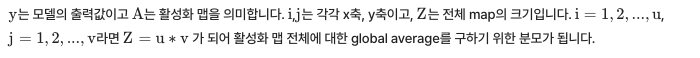
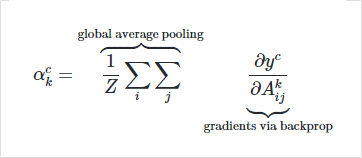
[k번째 채널의 그래디언트를 통해 가중치 점수를 구하는 식]  
https://arxiv.org/pdf/1610.02391.pdf  

이제 위의 식을 통해서 k 개의 채널을 가진 활성화 맵에서 각 채널이 어떤 클래스를 활성화하는 데 얼마나 중요하게 작용하는지 가중치 점수를 구할 수 있습니다. 이 가중치를 구하기 위해 CAM처럼 별도의 weight 파라미터를 도입할 필요가 없다는 것을 알 수 있습니다.

그러면 이 정보를 합쳐 활성화 맵에서 어떤 클래스의 위치에 따른 활성화를 보려면 어떻게 해야할까요? Grad-CAM은 이를 위해서 k번째 활성화 맵과 이 가중치를 곱해주어 합한 뒤 ReLU 활성화 함수를 통해서 클래스에 따른 Grad-CAM을 얻습니다. 이 수식을 시각화한 것이 맨 위에서 소개한 고양이와 개에 대한 Grad-CAM의 (c), (i)번째 예시입니다.  

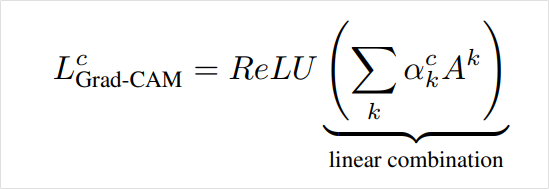
https://arxiv.org/pdf/1610.02391.pdf

### Q. 위 식에서 Grad-CAM을 계산하는 식을 볼 수 있습니다. 가장 마지막에 ReLU를 사용해주는데요. ReLU의 그래프 개형을 보고 왜 여기서 ReLU를 사용했는지 유추해봅시다.
ReLU를 사용함으로써 활성화된 영역을 확인해야 하기 때문에 불필요한 음의 값을 줄여줄 수 있습니다.

### 7-5. ACoL: Adversarial Complementary Learning
---
> 주요 참고 자료
    - Adversarial Complementary Learning for Weakly Supervised Object Localization https://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Adversarial_Complementary_Learning_CVPR_2018_paper.pdf  

CAM에서 신기한 점은 클래스와 이미지만을 데이터로 학습을 하는데 덤으로 위치 정보까지 얻을 수 있다는 것입니다. 이처럼 직접적으로 정답 위치 정보를 주지 않아도 간접적인 정보를 활용하여 학습하고 원하는 정보를 얻어낼 수 있도록 모델을 학습하는 방식을 약지도학습(weakly supervised learning) 이라고 합니다. 지금까지 봐왔던 CAM, Grad-CAM 그리고 지금 설명해 드리는 ACoL은 약지도학습 기법을 활용해 물체 검출(object detection)을 수행할 수 있습니다.

### 1) 약지도학습(weakly supervised learning)
---
딥러닝 관련 공부를 하다 보면 약지도학습과 준지도학습(semi-supervised learning)이라는 단어를 만날 수 있습니다. 두 개념이 실제로도 다소 혼용되기 때문에 다음과 같은 경우들로 나누어 생각해 보겠습니다. 아래 분류는 논문 A brief introduction to weakly supervised learning에서 정의된 것을 가져와서 정리한 것입니다.

- incomplete supervision : 학습 데이터 중 일부에만 라벨이 달린 경우. 일반적으로 말하는 준지도학습과 같은 경우임. (예: 개와 고양이 분류 학습 시 10,000개의 이미지 중 1,000개만 라벨이 있는 경우)

- inexact supervision : 학습데이터의 라벨이 충분히 정확하게 달려있지 않은 경우. (예: 개나 고양이를 Object Detection 또는 Semantic Segmentation해야 하지만 이미지 내에 정확한 bounding box는 주어져 있지 않고 이미지가 개인지 고양인지 정보만 라벨로 달려있는 경우)

- inaccurate supervision : 학습 데이터에 Noise가 있는 경우, (예: 개나 고양이의 라벨이 잘못 달린 경우)

약지도학습이란 위 3가지 경우를 포괄적으로 일컫도록 사용되곤 하지만, 오늘 우리가 다루고자 하는 것은 바로 inexact supervision에 해당하는 경우입니다. 일반적으로 Image Classification용 학습데이터보다는 bounding box 정보까지 정확하게 포함해야 하는 Object Detection이나 Semantic Segmentation을 위한 학습데이터가 훨씬 제작비용이 많이 듭니다.

아래는 Grad-CAM 논문에서 언급한 약지도학습을 통한 Object Detection과 Semantic Segmentation의 예시입니다.  
[Grad-CAM을 통한 Counterfactual Explanation]  
https://arxiv.org/pdf/1610.02391.pdf  
위 사진은 Grad-CAM을 통한 Counterfactual Explanation 예시입니다. 아이디어는 간단합니다. Grad-CAM을 통해서는 개와 고양이의 특징이 두드러지게 하는 영역의 가중치 점수를 계산할 수 있었지만, 해당 가중치 점수를 제거해 주면 Image classification 모델에서 해당 클래스에 대한 prediction이 바뀌게 될 수도 있습니다. 가중치 점수를 제거했을 때 prediction이 바뀌도록 하는 가중치 영역을 모으면 bounding box 라벨을 한 번도 보지 않고서도 object detection을 해낼 수 있다는 것입니다.  

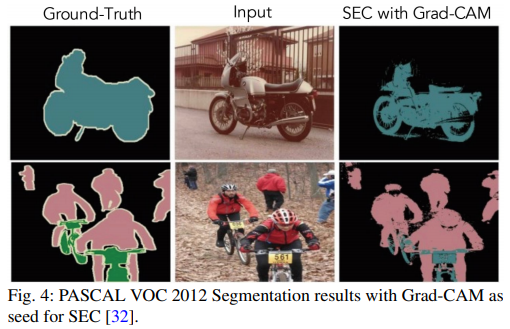  
[Grad-CAM을 이용한 Semantic Segmentation]  
https://arxiv.org/pdf/1610.02391.pdf  

또한 Grad-CAM을 이용해서, 위와 비슷한 논리로 Semantic Segmentation도 수행 가능함을 보여줍니다.

또 다른 예로, 네이버랩스의 이미지기반의 차선변경 알고리즘(SLC)은 무엇을 보면서 판단을 할까? 에서는 자율주행 연구에 약지도학습을 활용한 예를 확인할 수 있습니다.

### 2) Adversarial Complementary Learning
---
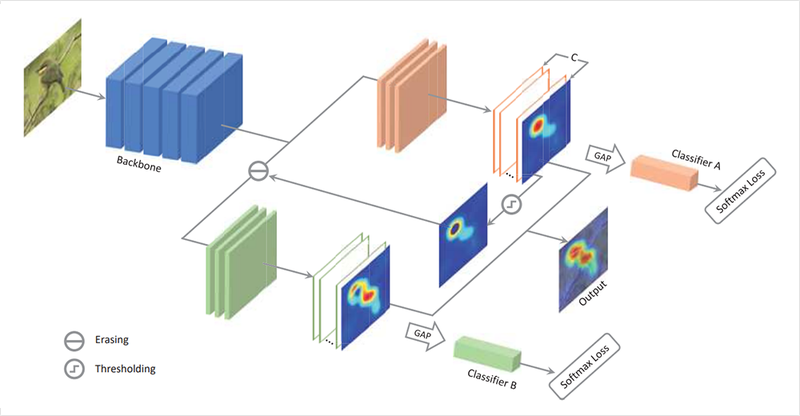  
http://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Adversarial_Complementary_Learning_CVPR_2018_paper.pdf
  
Adversarial의 뜻은 "적대적인"입니다. 그렇다면 논문 제목에서 사용된 Adversarial Complementary Learning (ACoL)은 어떤 방법일까요? 위 그림에서 볼 수 있듯이 ACoL은 모델의 학습에는 끝단이 두 브랜치(branch)로 나뉩니다. CAM을 만들기 위해 활용했던 특성 맵을 두 가지로 분리한 것입니다.  

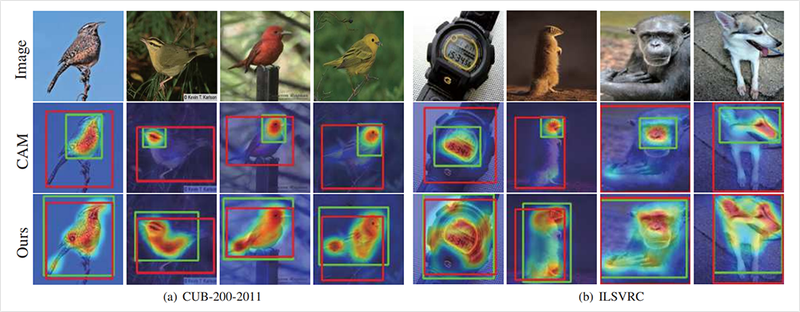  
http://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Adversarial_Complementary_Learning_CVPR_2018_paper.pdf  
CAM과 Grad-CAM은 Weaky-supervised 방식의 Object Detection, Segmentation의 가능성을 보여 주었습니다. 그러나 이들 방식에는 한 가지 문제가 있습니다. CAM을 통해 본 활성화 맵을 보면 가장자리보다는 특징이 주로 나타나는 위치에 중점적으로 활성화되는 모습을 볼 수 있습니다.

하지만 물체 검출(Object detection)은 새의 부리나 동물의 눈, 시계의 숫자와 같이 부분적 특성이 아닌 물체의 전체적인 형태와 윤곽을 정확하게 구분해 내는 것이 중요합니다. CAM 모델이 특정 부위에 집중해 학습하는 것을 막기 위해서 ACoL은 브랜치를 두 가지로 두어 너무 높은 점수를 지워줌으로써 주변의 특성 또한 반영하도록 했습니다. 이러한 과정을 논문에서는 Adversial, 즉 적대적인 학습방법이라고 합니다.

ACoL의 구조를 살펴보면 먼저 위쪽 주황색 브랜치를 거칩니다. 특성 맵은 GAP을 거쳐 CAM에서 보았던 소프트맥스 레이어인 Classifier A를 거치게 됩니다. 이 브랜치는 loss로 학습됩니다.

ACoL은 여기서 얻어진 활성화 맵을 적대적인 방법으로 사용합니다. 일정 값 이상 활성화된 활성화 맵을 지우도록 하는 것이지요. Classifier A는 쉽게 전체적인 이미지를 보고 클래스를 판별할 수 있는 반면에 Classifier B는 A의 CAM에서 크게 활성화된 영역을 지운 활성화 맵에서 분류를 해야 하기 때문에 더 어려운 문제를 푸는 것으로 볼 수 있습니다.

이렇게 두 가지 Classifier A와 Classifier B를 학습시킴으로써 더 넓은 영역을 판별의 근거로 삼을 수 있습니다. 이 과정을 통해서 모델은 쉽게 맞출 수 있는 샘플을 어렵게 다시 한 번 학습을 하는 Adversarial Complementary Learning 과정을 거치게 됩니다.

결과적으로 위 그림에서는 기존 CAM이 활성화되는 부분과 달리 ACoL은 물체의 전반적인 영역으로 CAM이 활성화되는 효과를 확인할 수 있습니다.

### 3) 1x1 Conv
---
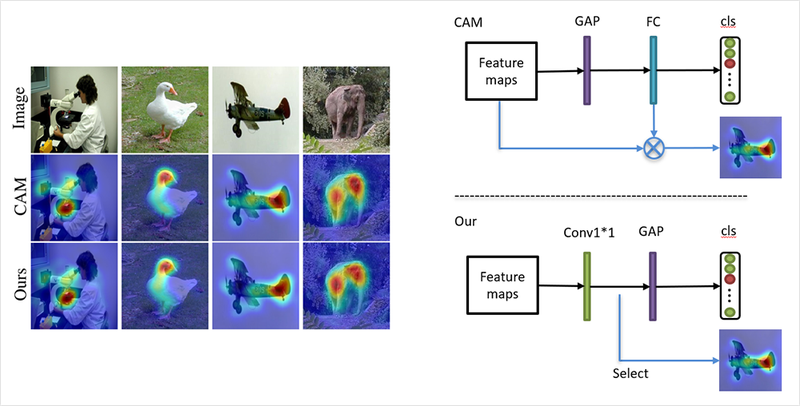  
http://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Adversarial_Complementary_Learning_CVPR_2018_paper.pdf  

CAM에서는 CAM을 얻기 위해서 대상이 되는 네트워크에 feed forward를 하고 활성화 맵과 가중치 계산을 다시 해주어야 합니다. 이 과정은 관찰하고자 하는 분류 모델의 feed forward와 별개의 작업이므로, 물체 검출을 위한 모델로 사용하기 위해서는 모델의 feed forward 외 별도의 연산을 해주어야 하는 단점이 있습니다.

ACoL 논문은 이를 개선하기 위해서 커널 사이즈는 1x1, 출력 채널의 개수는 분류하고자 하는 클래스 개수를 가진 컨볼루션 레이어를 특성 맵에 사용하고 여기에 GAP를 적용하여 Network in Network에서 본 구조와 유사한 방식을 사용하고 있습니다. 여기서 컨볼루션 레이어의 출력값은 곧바로 활성화 맵이 됩니다. 이렇게 구해진 활성화 맵과 CAM을 비교한 결과를 위 그림의 왼쪽에서 볼 수 있습니다.





#### Q. ACoL과 CAM 방식의 차이점을 정리해봅시다.
CAM은 단순하고 효율적으로 중요한 영역을 시각화할 수 있지만, 하나의 주요 영역에만 집중  
ACoL은 보완적 학습을 통해 더 다양한 영역을 학습하므로 복잡한 이미지나 다중 객체 탐지에 효과적

CAM : Fully Convolution Network -> GAP -> Fully Connected layer -> Softmax  
ACoL :Fully Convolution Network -> Convolution Layer -> GAP -> Softmax

### 7-6. 생각해 보기  

이제 분류 모델을 사용할 수 있을 뿐만 아니라 활성화 맵을 통해서 모델이 어느 영역을 보고 답을 내리는지도 알 수 있게 되었습니다.

CAM을 활용하면 멋진 프로젝트들을 만들 수 있습니다. 예컨대 황준식님의 CAM: 대선주자 얼굴 위치 추적기에서는 2017년 대선주자의 얼굴을 분류하고 이 모델을 기반으로 어느 위치에 얼굴이 있는지를 찾는 실험까지 구현합니다. 여기에 더해 Grad-CAM 이용한 딥페이크 (deepfake) 얼굴 탐지, 이외에도 다양한 상황에 사용된 소스가 있으니 참고해보시길 바랍니다.

이번에는 남들이 해둔 것이 아니라 직접 분류 및 시각화 모델을 만든다고 생각하고 이를 생각해보는 시간을 갖도록 하겠습니다. 아래의 질문들을 중심으로 어떻게 문제를 풀어나갈지 생각해보세요! 나중에 이를 직접 구현해본다면 정말 멋진 경험이 될 것입니다.

#### 생각해 볼 거리
---
- 어떤 분류문제를 풀고 싶은가요?
- 데이터를 어떻게 모을 수 있을까요?
- 어떤 모델을 기반으로 사용할까요?
- Class Activation Map을 활용해서 보여준다면 어떤 점이 좋을까요?

# 7-7. 마무리하며

### 종합 문제
---
지금까지 여러가지 XAI 기법들을 살펴보았습니다.

XAI(explainable AI)는 AI 모델의 동작과 결정 과정을 설명 가능한 방식으로 이해할 수 있도록 하는 개념으로, 컴퓨터 비전에서의 대표적인 방법은 CAM, Grad-CAM 이 있었습니다.

CAM(Class Activation Map)은 모델이 어떤 곳을 보고 어떤 클래스임을 짐작하고 있는지를 확인할 수 있는 지도로, Fully Convolution Network를 지나고 나온 Feature Map을 GAP(Global Average Pooling)을 거치고 FC layer(Fully Connected layer)를 지나 얻게 된 FC lyaer의 가중치를 얻은 다음, Fully Convolution Network를 지나고 나온 Feature Map에 첫번째 Step에서 얻어진 FC layer의 가중치와 행렬연산을 하여 Object Localization Map을 얻는 방식입니다.

CAM은 모델의 구조가 제한되는 문제점이 있어서 이를 해결하기위해 다양한 모델의 구조를 해석할 수 있는 방법인 Grad-CAM(Gradient CAM) 방법론이 제안되며, Grad-CAM 은 모델 구조를 변경할 필요 없이 구할 수 있다는 장점이 있습니다.

지금부터 여러분들이 얼마나 학습을 충실히 하셨는지 알아보려고 합니다. 배운 내용을 다시 생각하면서 아래의 퀴즈를 풀어보세요.

#### Q. Grad-CAM 방식을 작성해봅시다.
특징 맵 추출 - Gradient 계산 - 가중치 계산 - 가중 합산 - ReLU 적용 - 시각화

Grad-CAM을 만들기 위해서 Convolutional layer에서의 gradient를 활용하여 해당 gradient와 Convolutional layer's feature maps과 곱연산하여 추가적으로 ReLU Activation function을 거친 값을 input이미지에 heat-map표현을 해주는 것으로 Grad-CAM을 표현할 수 있다.